In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import tensorflow as tf

In [2]:
train_folder_path = r'C:./dataset/audioonly/labeled/set 2/Train'
os.path.exists(train_folder_path)

True

In [4]:
class_names = next(os.walk(train_folder_path))[1]
class_names = class_names[1:]
class_names

['belly_pain', 'discomfort', 'hungry', 'tired']

In [5]:
audio_path = [os.path.join(train_folder_path, name) for name in class_names]
audio_path

['C:./dataset/audioonly/labeled/set 2/Train\\belly_pain',
 'C:./dataset/audioonly/labeled/set 2/Train\\discomfort',
 'C:./dataset/audioonly/labeled/set 2/Train\\hungry',
 'C:./dataset/audioonly/labeled/set 2/Train\\tired']

In [6]:
bpain_audio = glob.glob(os.path.join(audio_path[0], '*.wav'))
discomf_audio = glob.glob(os.path.join(audio_path[1], '*.wav'))
hungry_audio = glob.glob(os.path.join(audio_path[2], '*.wav'))
tired_audio = glob.glob(os.path.join(audio_path[3], '*.wav'))

In [7]:
audio_path_byclass = {
    'bpain': bpain_audio,
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired': tired_audio
}

# Load Audio

In [8]:
# Replace 'your_audio_file.mp3' with the path to your audio file
load_audio = {}
for name, pathlst in audio_path_byclass.items():
    loaded = []
    for path in pathlst:
        audio, sr = librosa.load(path, sr=16000, mono=True, duration=5.2)
        loaded.append(audio)
    load_audio[name] = loaded

In [9]:
mfcc_audio = {}
for name, pathlst in audio_path_byclass.items():
    mfccs = []
    for path in pathlst:
        audio, sr = librosa.load(path, sr=16000, mono=True, duration=5.0)
        mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=10)
        mfccs.append(mfcc)
    mfcc_audio[name] = mfccs

In [10]:
import collections

shape = {}

for class_name, lst in mfcc_audio.items():
    for arr in lst:
        shapes = [arr.shape for arr in lst]
        shapes_count = collections.Counter(shapes)
        shape[f'{class_name} mfcc shape counts'] = shapes_count

In [11]:
shape

{'bpain mfcc shape counts': Counter({(10, 157): 69}),
 'discomf mfcc shape counts': Counter({(10, 157): 94}),
 'hungry mfcc shape counts': Counter({(10, 157): 100}),
 'tired mfcc shape counts': Counter({(10, 157): 69})}

## Load Model

In [12]:
# Load the model.
import tensorflow_hub as hub
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [13]:
# Run the model, check the output.
feature = {}
for name, arr in load_audio.items():
    # Initialize dictionaries for each class if not already existing
    if name not in feature:
        feature[name] = {'scores': [], 'embeddings': [], 'spectrograms': []}
    
    for wav in arr:
        scores, embeddings, spectrogram = model(wav)
        
        # Append the results to the respective lists in the dictionary
        feature[name]['scores'].append(np.array(scores))
        feature[name]['embeddings'].append(np.array(embeddings))
        feature[name]['spectrograms'].append(np.array(spectrogram))

In [14]:
shape_feat = {}

for class_name in feature.keys():
    for cat, lst in feature[class_name].items():
        shapes = [arr.shape for arr in lst]
        shapes_count = collections.Counter(shapes)
        shape_feat[f'{class_name} {cat} shape counts'] = shapes_count

In [15]:
shape_feat

{'bpain scores shape counts': Counter({(10, 521): 69}),
 'bpain embeddings shape counts': Counter({(10, 1024): 69}),
 'bpain spectrograms shape counts': Counter({(528, 64): 69}),
 'discomf scores shape counts': Counter({(10, 521): 94}),
 'discomf embeddings shape counts': Counter({(10, 1024): 94}),
 'discomf spectrograms shape counts': Counter({(528, 64): 94}),
 'hungry scores shape counts': Counter({(10, 521): 100}),
 'hungry embeddings shape counts': Counter({(10, 1024): 100}),
 'hungry spectrograms shape counts': Counter({(528, 64): 100}),
 'tired scores shape counts': Counter({(10, 521): 69}),
 'tired embeddings shape counts': Counter({(10, 1024): 69}),
 'tired spectrograms shape counts': Counter({(528, 64): 69})}

## Padding

In [16]:
from statistics import mean

temp = []

for class_cat, counter in shape_feat.items():
    for shape, count in counter.items():
        h, w = shape
        num_elements = h * w
        temp.append(num_elements)

In [17]:
avg = mean(temp)
avg

16414

In [18]:
for class_name, lst in mfcc_audio.items():
    feature[class_name]['mfcc'] = lst

In [19]:
shape_feat_3d = {}

for class_name in feature.keys():
    for cat, lst in feature[class_name].items():
        shapes = [arr.shape for arr in lst]
        shapes_count = collections.Counter(shapes)
        shape_feat_3d[f'{class_name} {cat} shape counts'] = shapes_count

In [20]:
shape_feat_3d

{'bpain scores shape counts': Counter({(10, 521): 69}),
 'bpain embeddings shape counts': Counter({(10, 1024): 69}),
 'bpain spectrograms shape counts': Counter({(528, 64): 69}),
 'bpain mfcc shape counts': Counter({(10, 157): 69}),
 'discomf scores shape counts': Counter({(10, 521): 94}),
 'discomf embeddings shape counts': Counter({(10, 1024): 94}),
 'discomf spectrograms shape counts': Counter({(528, 64): 94}),
 'discomf mfcc shape counts': Counter({(10, 157): 94}),
 'hungry scores shape counts': Counter({(10, 521): 100}),
 'hungry embeddings shape counts': Counter({(10, 1024): 100}),
 'hungry spectrograms shape counts': Counter({(528, 64): 100}),
 'hungry mfcc shape counts': Counter({(10, 157): 100}),
 'tired scores shape counts': Counter({(10, 521): 69}),
 'tired embeddings shape counts': Counter({(10, 1024): 69}),
 'tired spectrograms shape counts': Counter({(528, 64): 69}),
 'tired mfcc shape counts': Counter({(10, 157): 69})}

In [21]:
reshaped = {}

for class_name, categories in feature.items():
    for cat, lst in categories.items():
        temp = []
        for arr in lst:
            h, w = arr.shape
            flat_arr = arr.flatten()
            size = h * w

            if size == 5210 or size == 1570 or size == 10240:
                padded = np.pad(flat_arr, pad_width=(0, avg - size), mode='constant', constant_values=0)
                temp.append(padded)
            else:
                trunc_arr = flat_arr[:avg]
                temp.append(trunc_arr) 
        
        reshaped[f'{class_name} {cat}'] = temp

In [22]:
shape_count = {}

for class_name, lst in reshaped.items():
    shapes = [arr.shape for arr in lst]
    shapes_count = collections.Counter(shapes)
    shape_count[f'{class_name} shape counts'] = shapes_count

In [23]:
shape_count

{'bpain scores shape counts': Counter({(16414,): 69}),
 'bpain embeddings shape counts': Counter({(16414,): 69}),
 'bpain spectrograms shape counts': Counter({(16414,): 69}),
 'bpain mfcc shape counts': Counter({(16414,): 69}),
 'discomf scores shape counts': Counter({(16414,): 94}),
 'discomf embeddings shape counts': Counter({(16414,): 94}),
 'discomf spectrograms shape counts': Counter({(16414,): 94}),
 'discomf mfcc shape counts': Counter({(16414,): 94}),
 'hungry scores shape counts': Counter({(16414,): 100}),
 'hungry embeddings shape counts': Counter({(16414,): 100}),
 'hungry spectrograms shape counts': Counter({(16414,): 100}),
 'hungry mfcc shape counts': Counter({(16414,): 100}),
 'tired scores shape counts': Counter({(16414,): 69}),
 'tired embeddings shape counts': Counter({(16414,): 69}),
 'tired spectrograms shape counts': Counter({(16414,): 69}),
 'tired mfcc shape counts': Counter({(16414,): 69})}

In [24]:
# Initialize a dictionary to store the concatenated arrays
concatenated_arrays = {}

# Iterate over each class
for class_prefix in ['bpain', 'discomf', 'hungry', 'tired']:
    scores = reshaped[f'{class_prefix} scores']
    embeddings = reshaped[f'{class_prefix} embeddings']
    spectrograms = reshaped[f'{class_prefix} spectrograms']
    mfccs = reshaped[f'{class_prefix} mfcc']

    # Ensure all lists are the same length
    if len(scores) == len(embeddings) == len(spectrograms)== len(mfccs):
        concatenated_arrays[class_prefix] = []

        # Concatenate corresponding arrays from each category
        for i in range(len(scores)):
            concatenated = np.concatenate([scores[i], embeddings[i], spectrograms[i], mfccs[i]])
            concatenated_arrays[class_prefix].append(concatenated)
    else:
        print(f"Warning: Mismatch in lengths for {class_prefix} class")

In [25]:
concat_count = {}

for class_name, lst in concatenated_arrays.items():
    shapes = [arr.shape for arr in lst]
    shapes_count = collections.Counter(shapes)
    concat_count[f'{class_name} shape counts'] = shapes_count

In [26]:
concat_count

{'bpain shape counts': Counter({(65656,): 69}),
 'discomf shape counts': Counter({(65656,): 94}),
 'hungry shape counts': Counter({(65656,): 100}),
 'tired shape counts': Counter({(65656,): 69})}

In [27]:
from sklearn.model_selection import train_test_split

# Combine data and labels
data = []
labels = []
for class_name, arrays in concatenated_arrays.items():
    data.extend(arrays)
    labels.extend([class_name] * len(arrays))

# Convert to numpy arrays if not already
data = np.array(data)
labels = np.array(labels)

# Shuffle and split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [28]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(labels)
y_test = label_encoder.transform(y_test)

In [29]:
print(data.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(332, 65656)
(332,)
(67, 65656)
(67,)


## **Test Data**

In [30]:
# test_folder_path = r'C:./dataset/audioonly/labeled/set 1/Test'

In [31]:
# class_names_test = next(os.walk(test_folder_path))[1]
# class_names_test = class_names_test
# class_names_test

In [32]:
# audio_path_test = [os.path.join(test_folder_path, name) for name in class_names_test]
# audio_path_test

In [33]:
# bpain_audio_test = glob.glob(os.path.join(audio_path_test[0], '*.wav'))
# discomf_audio_test = glob.glob(os.path.join(audio_path_test[1], '*.wav'))
# hungry_audio_test = glob.glob(os.path.join(audio_path_test[2], '*.wav'))
# tired_audio_test = glob.glob(os.path.join(audio_path_test[3], '*.wav'))

In [34]:
# audio_testnum_byclass = {
#     'bpain': bpain_audio_test,
#     'discomf': discomf_audio_test,
#     'hungry': hungry_audio_test,
#     'tired': tired_audio_test
# }

In [35]:
# # Replace 'your_audio_file.mp3' with the path to your audio file
# load_audio_test = {}
# for name, pathlst in audio_testnum_byclass.items():
#     loaded = []
#     for path in pathlst:
#         audio, sr = librosa.load(path, sr=16000, mono=True, duration=5.2)
#         loaded.append(audio)
#     load_audio_test[name] = loaded

In [36]:
# mfcc_audio_test = {}
# for name, pathlst in audio_testnum_byclass.items():
#     mfccs = []
#     for path in pathlst:
#         audio, sr = librosa.load(path, sr=16000, mono=True, duration=5.0)
#         mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=10)
#         mfccs.append(mfcc)
#     mfcc_audio_test[name] = mfccs

In [37]:
# import collections

# shape_test = {}

# for class_name, lst in mfcc_audio_test.items():
#     for arr in lst:
#         shapes = [arr.shape for arr in lst]
#         shapes_count = collections.Counter(shapes)
#         shape_test[f'{class_name} mfcc shape counts'] = shapes_count

In [38]:
# shape_test

In [39]:
# # Run the model, check the output.
# feature_test = {}
# for name, arr in load_audio_test.items():
#     # Initialize dictionaries for each class if not already existing
#     if name not in feature_test:
#         feature_test[name] = {'scores': [], 'embeddings': [], 'spectrograms': []}
    
#     for wav in arr:
#         scores, embeddings, spectrogram = model(wav)
        
#         # Append the results to the respective lists in the dictionary
#         feature_test[name]['scores'].append(np.array(scores))
#         feature_test[name]['embeddings'].append(np.array(embeddings))
#         feature_test[name]['spectrograms'].append(np.array(spectrogram))

In [40]:
# shape_feat_test = {}

# for class_name in feature_test.keys():
#     for cat, lst in feature_test[class_name].items():
#         shapes = [arr.shape for arr in lst]
#         shapes_count = collections.Counter(shapes)
#         shape_feat_test[f'{class_name} {cat} shape counts'] = shapes_count

In [41]:
# shape_feat_test

In [42]:
# for class_name, lst in mfcc_audio_test.items():
#     feature_test[class_name]['mfcc'] = lst

In [43]:
# reshaped_test = {}

# for class_name, categories in feature_test.items():
#     for cat, lst in categories.items():
#         temp = []
#         for arr in lst:
#             h, w = arr.shape
#             flat_arr = arr.flatten()
#             size = h * w

#             if size == 5210 or size == 1570 or size == 10240:
#                 padded = np.pad(flat_arr, pad_width=(0, avg - size), mode='constant', constant_values=0)
#                 temp.append(padded)
#             else:
#                 trunc_arr = flat_arr[:avg]
#                 temp.append(trunc_arr) 
        
#         reshaped_test[f'{class_name} {cat}'] = temp

In [44]:
# shape_count_test = {}

# for class_name, lst in reshaped_test.items():
#     shapes = [arr.shape for arr in lst]
#     shapes_count = collections.Counter(shapes)
#     shape_count_test[f'{class_name} shape counts'] = shapes_count

In [45]:
# shape_count_test

In [46]:
# # Initialize a dictionary to store the concatenated arrays
# concat_arr_test = {}

# # Iterate over each class
# for class_prefix in ['bpain', 'discomf', 'hungry', 'tired']:
#     scores = reshaped_test[f'{class_prefix} scores']
#     embeddings = reshaped_test[f'{class_prefix} embeddings']
#     spectrograms = reshaped_test[f'{class_prefix} spectrograms']
#     mfccs = reshaped_test[f'{class_prefix} mfcc']

#     # Ensure all lists are the same length
#     if len(scores) == len(embeddings) == len(spectrograms)== len(mfccs):
#         concat_arr_test[class_prefix] = []

#         # Concatenate corresponding arrays from each category
#         for i in range(len(scores)):
#             concatenated = np.concatenate([scores[i], embeddings[i], spectrograms[i], mfccs[i]])
#             concat_arr_test[class_prefix].append(concatenated)
#     else:
#         print(f"Warning: Mismatch in lengths for {class_prefix} class")

In [47]:
# concat_count_test = {}

# for class_name, lst in concat_arr_test.items():
#     shapes = [arr.shape for arr in lst]
#     shapes_count = collections.Counter(shapes)
#     concat_count_test[f'{class_name} shape counts'] = shapes_count

In [48]:
# concat_count_test

In [49]:
# # Combine data and labels
# x_test = []
# y_test = []
# for class_name, arrays in concat_arr_test.items():
#     x_test.extend(arrays)
#     y_test.extend([class_name] * len(arrays))

# # Convert to numpy arrays if not already
# x_test = np.array(x_test)
# y_test = np.array(y_test)

In [50]:
# label_encoder = LabelEncoder()
# y_test = label_encoder.fit_transform(y_test)

In [51]:
# print(x_test.shape)
# print(y_test.shape)

## Model Training

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation

model = Sequential([
    Dense(128, input_shape=(65656,)),  # First hidden layer
    BatchNormalization(),              # Batch normalization for the first hidden layer
    Activation('sigmoid'),                # Activation for the first hidden layer

    Dense(64),                        # Second hidden layer
    BatchNormalization(),              # Batch normalization for the second hidden layer
    Activation('sigmoid'),                # Activation for the second hidden layer

    Dense(32),                         # Third hidden layer
    BatchNormalization(),              # Batch normalization for the third hidden layer
    Activation('sigmoid'),             # Activation for the third hidden layer

    Dense(16),                         # Fourth hidden layer
    BatchNormalization(),              # Batch normalization for the fourth hidden layer
    Activation('sigmoid'),

    Dense(4, activation='softmax')     # Output layer
])

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8404096   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 64)                0

In [53]:
history = model.fit(data,
                    y_train,
                    validation_data=(x_test, y_test),
                    epochs=30,
                    batch_size=4)

Epoch 1/30
83/83 [==============================] - 2s 11ms/step - loss: 1.4494 - accuracy: 0.3855 - val_loss: 1.3913 - val_accuracy: 0.3731
Epoch 2/30
83/83 [==============================] - 1s 7ms/step - loss: 1.2773 - accuracy: 0.4127 - val_loss: 1.3217 - val_accuracy: 0.3731
Epoch 3/30
83/83 [==============================] - 1s 7ms/step - loss: 1.2226 - accuracy: 0.4880 - val_loss: 1.2094 - val_accuracy: 0.4627
Epoch 4/30
83/83 [==============================] - 1s 7ms/step - loss: 1.1629 - accuracy: 0.5060 - val_loss: 1.1376 - val_accuracy: 0.4776
Epoch 5/30
83/83 [==============================] - 1s 7ms/step - loss: 1.1783 - accuracy: 0.5151 - val_loss: 1.0503 - val_accuracy: 0.5224
Epoch 6/30
83/83 [==============================] - 1s 7ms/step - loss: 1.1460 - accuracy: 0.5030 - val_loss: 1.1537 - val_accuracy: 0.5373
Epoch 7/30
83/83 [==============================] - 1s 7ms/step - loss: 1.1108 - accuracy: 0.5181 - val_loss: 1.0049 - val_accuracy: 0.6119
Epoch 8/30
83/83 [=

In [54]:
model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.3845 - accuracy: 0.9254


[0.38445761799812317, 0.9253731369972229]

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

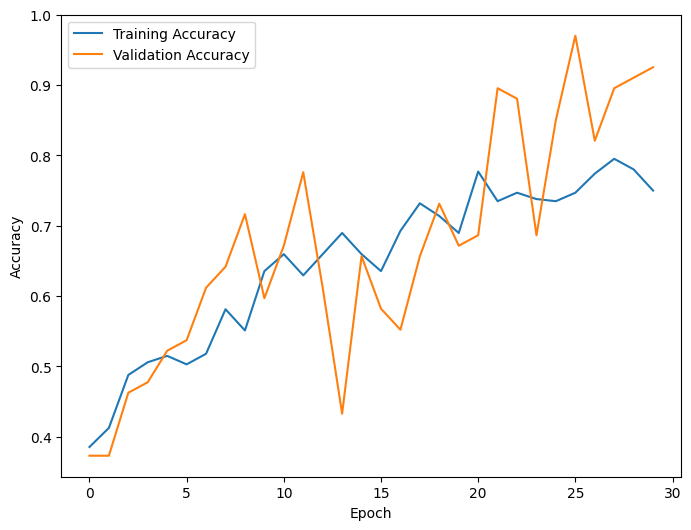

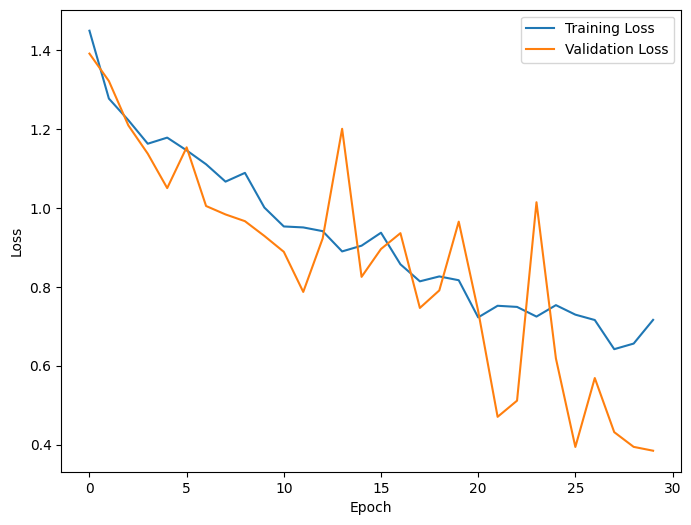

In [56]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## XGBoost

In [57]:
# train = np.load(r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\set 2\xtrain.npy")
# label = np.load(r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\set 2\ytrain.npy")
# test = np.load(r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\set 2\xtest.npy")
# test_label = np.load(r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\set 2\ytest.npy")

In [58]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)
model.fit(data, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


## random forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier model
model = RandomForestClassifier(n_estimators=300, random_state=42)

# Train the model
model.fit(data, y_train)

# Predict the labels for the test set
y_pred = model.predict(x_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%
